# Assignment 1
## Sentiment Analysis <br\>

### Pre - Dependencies and File Loading

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import re
import numpy as np
import html
import warnings
from functools import reduce
from collections import OrderedDict as od
import matplotlib.pyplot as plt

In [3]:
#load unclassified data
unclassified = list()
with open('unclassified_tweets.txt','r') as f:
    for data in f.readlines():
        if data.strip():
            unclassified.append(data.strip())
        
#conatain in a dataframe for future use 
unclassified = pd.DataFrame(unclassified,columns=['text'])

In [4]:
#load unclassified data
classified = pd.read_csv('classified_tweets.txt')

In [5]:
#load stop words
stop_words = list()
with open('stop_words.txt','r') as f:
    for stop_word in f.readlines():
        if data.strip():
            stop_words.append(stop_word.strip())

### Q1 - Data Cleaning
Creat a data cleaner class to perform the data cleaning procedure in sequence:
- Encode according to ASCII
- Remove html tag
- Remove url
- Change to lower cases
- remove stop words
- extract hash tags
- Remove all non-alphanumerical charactors

In [6]:
class DataCleaner(object):
    
    def __init__(self,stopWords,removeProcudreInd:int=False):
        super().__init__()
        self.hashtag = str()
        self.stopwords = set(stopWords) #hash it for O(1) check
        
        #use reflection to define the cleaning pipeline -> form of list of method pointers, sorted by name
        self.procedures = [getattr(self,attr) for attr in \
                           re.findall(r'(run_.*?)(?:\s)',' '.join(sorted(dir(self))))]
        
        #drop the disired procudure if user needs
        if removeProcudreInd is not False:
            self.procedures.pop(removeProcudreInd-1)
            
    #use reduce to sequentially clean the raw data, equivelent to funcN(...func2(func1(data)))
    def clean(self,data):
        return reduce(lambda data,func:func(data),[' '+data+' ']+self.procedures),self.hashtags
    
    def run_01_to_ascii(self,data):
        return html.unescape(data)
    
    #remove html tag in form of <...>
    def run_02_remove_html_tag(self,data):
        return re.sub(r"\s*<.*?>",'', data)
    
    #remove url in form of (http or https://)address.domain(/file)
    def run_03_remove_url(self,data):
        return re.sub(r'\s*(?:https?:\/\/)?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?#[\]@!\$&\'\(\)\*\+,;=.]+','',data)

    def run_04_to_lower(self,data):
        return data.lower()
    
    def run_07_remove_all_nonAlphaNumerical_char(self,data):
        return re.sub(r'[^\s\w]+','',data)
    
    def run_05_remove_stop_words(self,data):
        words = data.split()
        for ind,word in enumerate(words):
            if word in self.stopwords:
                words[ind]=''
        return ' '.join(filter(lambda x:x, words)) #clean up empty charactor
    
    def run_06_hash_tag_retrieval(self,data):
        self.hashtags = ' '.join(re.findall(r'(?:#)(.*?)(?:\s)',data))
        return re.sub(r'#.*?\s','',data)

In [7]:
#create a data cleaner instance
thisDataCleaner = DataCleaner(stop_words)

In [8]:
#clean all the unclassified text in pandas with vectorized method
unclassified['text'],unclassified['hash tags'] = np.vectorize(thisDataCleaner.clean)(unclassified['text'])

In [9]:
unclassified.head()

,text,hash tags
0,living dream tommulcair,cameraman camera cameraception camera cameras ...
1,justin reasons thanksgiving todays montrealthe...,trudeau's elxn42 quebec
2,themadape buttre allergic latex sneeze cdnpoli,nbpoli
3,2 massive explosions peace march 30 killed tur...,turkey. cdnpoli
4,suggests theres bad blood ndp,mulcair trudeau ready4change


In [10]:
#clean all the classified text in pandas with vectorized method
classified['text'],classified['hash tags'] = np.vectorize(thisDataCleaner.clean)(classified['text'])

In [11]:
classified.head()

,class,id,date,query,user,text,hash tags
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot awww thats bummer shoulda david ca...,
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting cry result schoo...,
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived times ball managed save 50 rest...,
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,body feels itchy fire,
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its behaving all im mad her...,


### Q2 - Exploratory Analysis
Creat a party labeller class to perform party labelling procedure.  
One tweeter may contains multiples of parties mentioned in the text.  
Count them all, sort in a seperate pandas series and plot by bar chart and pie chart.   

In [12]:
class PartyLabeller(object):
    
    #default party dictionary -> {party:keywords}
    partyDict ={'Liberal': {'lpc', 'liberal', 'liberals', 'realchange', \
                        'justin', 'trudeau', 'trudeaus', 'justintrudeau','ptlib'},\
            
            'Conservative':{'cpc','pttory', 'conservative', 'conservatives', 'stephenharper', 'harper', 'harpers','tcot'},\
            
            'New Democratic':{'ndp', 'ptndp','npd','tommulcair', 'tommulcairs', 'thomasmulcair',\
                   'readyforchange', 'ready4change', 'mulcair', 'mulcairs'}}
    
    @staticmethod
    def partyDictMod(partyDict:dict):
        for key in partyDict:
            if not partyDict[key]:
                raise Exception('Void dictionary value is not valid: {}'.format({key:partyDict[key]}))
        PartyLabeller.partyDict = partyDict            
        warnings.warn("Party dictionary changed, reinitialize existing instance if needed.")
                
    def __init__(self,partyDict:dict=False):
        super().__init__()
        if partyDict is False:
            partyDict = PartyLabeller.partyDict
        #flip (invert) the map, in use for O(1) check -> target form: {keyword:party}
        self.partyDict = {keyWord: party for party,keyWords in partyDict.items() for keyWord in keyWords}
    
    def label_party(self,primeData,sencondaryData=False):
        labels = self.label_data(primeData)
        if not labels and sencondaryData is not False:
            labels = self.label_data(sencondaryData)
        return labels
        
    def label_data(self,data):
        #traversal candidate key words, return the party label if match found. contain in a frozenset for hashable
        return frozenset([self.partyDict[keyWord] for keyWord in self.partyDict if re.match('.*'+keyWord+'.*',data)])

In [13]:
#create a data cleaner instance
thisPartyLabller = PartyLabeller()

In [14]:
#label the unclassified text in pandas with vectorized method (use hash tag first, if label not found, use text)
unclassified['party labels'] = np.vectorize(thisPartyLabller.label_party)(unclassified['hash tags'],unclassified['text'])
unclassified.head()

,text,hash tags,party labels
0,living dream tommulcair,cameraman camera cameraception camera cameras ...,(New Democratic)
1,justin reasons thanksgiving todays montrealthe...,trudeau's elxn42 quebec,(Liberal)
2,themadape buttre allergic latex sneeze cdnpoli,nbpoli,()
3,2 massive explosions peace march 30 killed tur...,turkey. cdnpoli,()
4,suggests theres bad blood ndp,mulcair trudeau ready4change,"(Liberal, New Democratic)"


Conservative      714
Liberal           801
New Democratic    497
dtype: int64

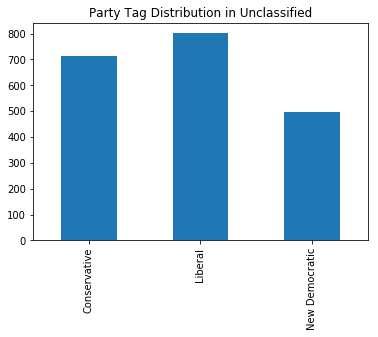

In [15]:
#Count the party tags
unclassifiedLabelCounter = {key:0 for key in PartyLabeller.partyDict}
for labels,value in unclassified.groupby('party labels').size()[1:].iteritems():
    for key in labels:
        unclassifiedLabelCounter[key] += value
#bar plot
unclassifiedLabelCounter = pd.Series(unclassifiedLabelCounter)
plot = unclassifiedLabelCounter.plot(kind='bar',title='Party Tag Distribution in Unclassified')
unclassifiedLabelCounter

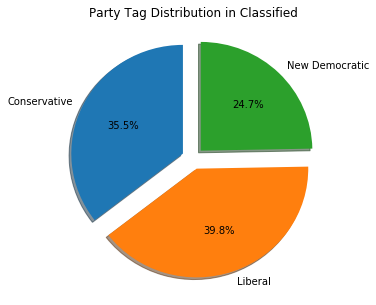

In [16]:
#pie plot
fig=plt.figure(figsize=(5, 5))
plt.axis('off')
plot = unclassifiedLabelCounter.plot(kind='pie',explode=tuple([0.1]*len(PartyLabeller.partyDict)),\
                            shadow=True,startangle=90,autopct='%2.1f%%',title='Party Tag Distribution in Classified')

In [17]:
#label the classified text in pandas with vectorized method
classified['party labels'] = np.vectorize(thisPartyLabller.label_party)(classified['hash tags'],classified['text'])
classified.head()

,class,id,date,query,user,text,hash tags,party labels
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot awww thats bummer shoulda david ca...,,()
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting cry result schoo...,,()
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived times ball managed save 50 rest...,,()
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,body feels itchy fire,,()
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its behaving all im mad her...,,()


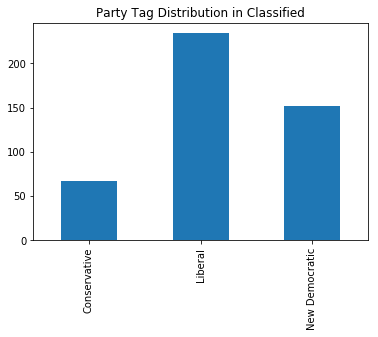

In [18]:
#Count the party tags
classifiedLabelCounter = {key:0 for key in PartyLabeller.partyDict}
for labels,value in classified.groupby('party labels').size()[1:].iteritems():
    for key in labels:
        classifiedLabelCounter[key] += value

#bar plot
classifiedLabelCounter = pd.Series(classifiedLabelCounter)
plot=classifiedLabelCounter.plot(kind='bar',title='Party Tag Distribution in Classified')

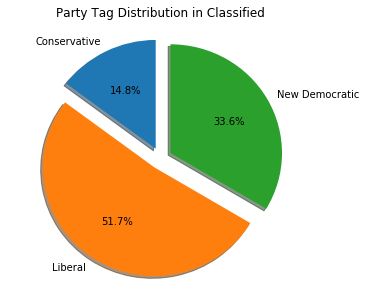

In [19]:
#pie plot
fig=plt.figure(figsize=(5, 5))
plt.axis('off')
plot = classifiedLabelCounter.plot(kind='pie',explode=tuple([0.1]*len(PartyLabeller.partyDict)),\
                            shadow=True,startangle=90,autopct='%2.1f%%',title='Party Tag Distribution in Classified')

### Q3 - Model Preparation
Prepare the data for model training and testing in sequense:
- binarize the class tags
- split data for 70% training use and 30% test use
- tokenizing the text in term frequency–inverse document (TF-IDF) frequency form

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB as bnb
from sklearn.svm import SVC as svc
from sklearn.linear_model import LogisticRegression as lr
from sklearn.naive_bayes import MultinomialNB as mnb
from sklearn.naive_bayes import BernoulliNB as bnb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [21]:
# binarize labels 0->0, 4->1
classified['binarized'] = classified['class'].map(lambda x:1 if x else 0)

# split data, 30% for test and 70% for training
X_train, X_test, y_train, y_test = train_test_split(classified['text'],classified['binarized'],test_size=0.3)

# transform all text data into TF-IDF features
tfidf_vectorize = TfidfVectorizer(stop_words='english')
X_train = tfidf_vectorize.fit_transform(X_train)
X_test = tfidf_vectorize.transform(X_test)

### Q4 - Model Implementation
Creat a classifiers class to develop a set of classifiers (currently Logistic Regression, Multinomial Naive Bayes and Bernoulli Naive Bayes included).
These classifiers could be constructed by training only or train with hyper-parameters tuning
A full analysis on the classifiers would be given based on the prediction of test data 

In [22]:
class Classifiers(object):

    def __init__(self,train_data,train_labels,hyperTune=True,lrOnly=False,truncated:'pass a None for all data'=20000):
        super().__init__()
        self.train_data = train_data[:truncated]
        self.train_labels = train_labels[:truncated]
        self.construct_all_models(hyperTune,lrOnly)
        
    #3 models LR MNB and BNB
    def construct_all_models(self,hyperTune,lrOnly):
        if hyperTune:
            print('''
            
Hint: This mode may take 10 min or more for full futures training on CPU, please be patient and have a cup of coffee... or maybe cups of
I\'d rather suggest run the train-only mode, which contains the optimal hyper-parameters tuned before.
''')
            print ('Hyper Parameter Tuning Mode:\n')
            #prepare the candidate models and their hyper-parameter candidates
            self.models=od([('LogisticRegression',[lr(),dict(C=np.arange(0.1,3,0.5))]),\
                            ('MultinomialNB',[mnb(),dict(alpha=np.arange(0.1,10,1))]),\
                            ('BernoulliNB',[bnb(),dict(alpha=np.arange(0.1,10,1))])])
            for name,candidate_hyperParam in self.models.items():
                #update each classifier after training and tuning
                self.models[name] = self.train_with_hyperParamTuning(candidate_hyperParam[0],name,candidate_hyperParam[1])
                if lrOnly:
                    break;
        #an SVM for bonus if you don't use hyper-parameter tune mode
        else:
            print ('Training with Default Hyper Parameters:\n')
            self.models=od([('LogisticRegression',lr(C=1.1)),\
                            ('MultinomialNB',mnb(alpha=7)),\
                            ('BernoulliNB',bnb(alpha=3.1)),\
                            ('SVM',svc(kernel='linear',probability=True,C=1.21))])
            for name,model in self.models.items():
                #update each classifier after training
                self.models[name] = self.train(model,name)
                if lrOnly:
                    break
        print ('\nTraining process finished\n\n\n')
    
    # Training with hyper-parameter tuning, return the best model after exhaustive search in GridSearchCV
    def train_with_hyperParamTuning(self,model,name,param_grid):
        #grid search method for hyper-parameter tuning
        grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', n_jobs=-1) # keep 10% for cross validation
        grid.fit(self.train_data, self.train_labels)
        print(
            '\n-> The best hyper-parameter for {} is {}, the corresponding score through 10 Fold test is {} \n'\
            .format(name, grid.best_params_, grid.best_score_))
        #best model after training
        bestModel = grid.best_estimator_
        train_pred = bestModel.predict(self.train_data)
        print(' {} train accuracy = {}\n'.format(name,(train_pred == self.train_labels).mean()))
        return bestModel
    
    # Training only
    def train(self,model,name):
        model = model.fit(self.train_data,self.train_labels)
        train_pred = model.predict(self.train_data)
        print(' \n-> {} train accuracy = {}\n'.format(name,(train_pred == self.train_labels).mean()))
        return model
    
    #offer all the metrics for the classifier
    def prediction_metrics(self,test_data,test_labels,name):
        try:
            pred_labels = self.models[name].predict(test_data)
        except:
            print('Model not trained yet')
            return
        
        #accuracy
        print('-> Test Accuracy: {} test accuracy = {}\n'.format(name,(pred_labels == test_labels).mean()))
        
        #report
        print('\n-> General Report:\n\n',classification_report(test_labels, pred_labels),'\n')
        
        #AUC (Area Under Curve) of ROC
        prob = self.models[name].predict_proba(test_data)
        auc=roc_auc_score(test_labels.reshape(-1),prob[:,1])
        print('\n-> ROC plot and Corresponding AUC: \n\n Classifier {} area under curve of ROC is {}\n'.format(name,auc))

        #ROC
        fpr, tpr, thresholds = roc_curve(test_labels.values.reshape(-1), prob[:,1], pos_label=1)
        self.roc_plot(fpr,tpr,name,auc)
        
    #plot ROC
    def roc_plot(self,fpr,tpr,name,auc):
        plt.figure(figsize=(20,5))
        plt.plot(fpr,tpr)
        plt.ylim([0.0,1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC of {}     AUC: {}'.format(name,auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True)
        plt.show()

In [23]:
#Training
thisClassifiers = Classifiers(X_train,y_train,hyperTune=False,lrOnly=True,truncated=None)

Training with Default Hyper Parameters:

 
-> LogisticRegression train accuracy = 0.8270714285714286


Training process finished





-> Test Accuracy: LogisticRegression test accuracy = 0.7417


-> General Report:

              precision    recall  f1-score   support

          0       0.76      0.71      0.73     30083
          1       0.73      0.77      0.75     29917

avg / total       0.74      0.74      0.74     60000
 


-> ROC plot and Corresponding AUC: 

 Classifier LogisticRegression area under curve of ROC is 0.8211636972185667



/Users/leehh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


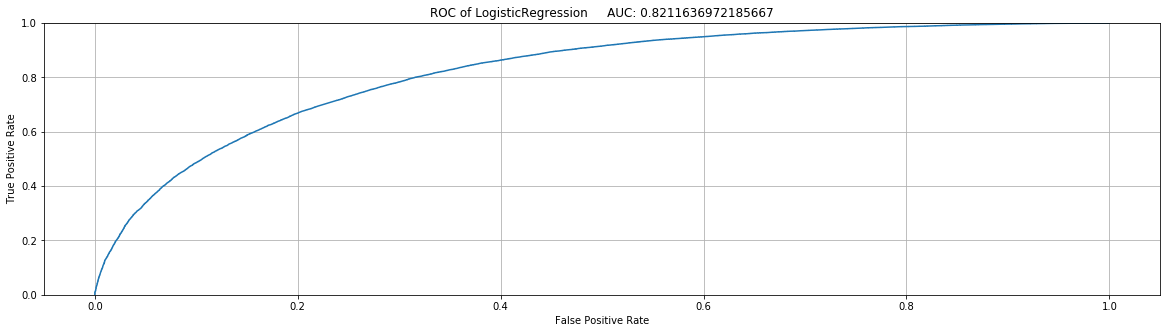

In [24]:
#evaluate the logistic regression classifier based on the test set
thisClassifiers.prediction_metrics(X_test,y_test,'LogisticRegression')

In [25]:
#Extract the TF-IDF features of unclassified text and predict the class
unclassified['class'] = thisClassifiers.models['LogisticRegression'].predict(\
                                                            tfidf_vectorize.transform(unclassified['text']))
unclassified.head()

,text,hash tags,party labels,class
0,living dream tommulcair,cameraman camera cameraception camera cameras ...,(New Democratic),0
1,justin reasons thanksgiving todays montrealthe...,trudeau's elxn42 quebec,(Liberal),1
2,themadape buttre allergic latex sneeze cdnpoli,nbpoli,(),0
3,2 massive explosions peace march 30 killed tur...,turkey. cdnpoli,(),0
4,suggests theres bad blood ndp,mulcair trudeau ready4change,"(Liberal, New Democratic)",0


##### Sentiment anaylysis on different parties

In [26]:
#sum up the positive and negative sentiment on each party, contained in a data frame
sumDf = pd.DataFrame(np.zeros((len(PartyLabeller.partyDict),2)),index=[key for key in PartyLabeller.partyDict],\
                     columns=[0,1])
def count(data):
    for label in data['party labels']:
        sumDf.set_value(label,data['class'],sumDf.get_value(label,data['class'], takeable=False)+1)
        
unclassified.apply(count,axis=1)
sumDf.columns=['negative','positive']
sumDf

,negative,positive
Liberal,250.0,551.0
Conservative,243.0,471.0
New Democratic,147.0,350.0


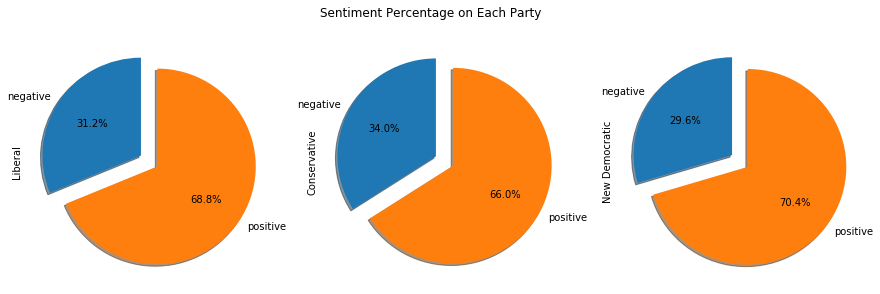

In [27]:
#Plot of Sentiment Percentage on Each Party
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,4.5))
plt.suptitle('Sentiment Percentage on Each Party')
for n,key in enumerate(sumDf.index):
    sumDf.loc[key].plot(kind='pie',explode=(0.1, 0.1),shadow=True,startangle=90,\
                        autopct='%2.1f%%',ax=axes[n])

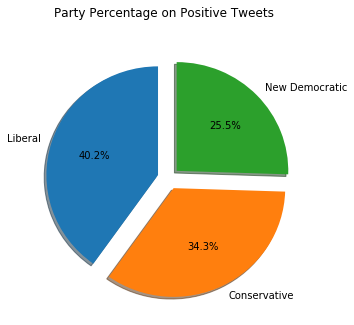

In [28]:
# Plot of Party Percentage on Positive Tweets
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(5,5))
plt.suptitle('Party Percentage on Positive Tweets')
plt.axis('off')
plot = sumDf['positive'].plot(kind='pie',explode=tuple([0.1]*len(PartyLabeller.partyDict)),\
                       shadow=True,startangle=90,autopct='%2.1f%%')

### Q5 - Discussion
The most frequent party that mentioned on classified Tweets file is Liberal, followed by New Democratic (234:152:67). As for unclassified file, the sequence is Liberal, Conservative, and New Democratic (801:714:497).   
Sentiment predicted by the model indicates that all 3 parties received positive comments over the negatives. Among the positive Tweets, Liberal party holds the majority portion, which indicates Liberal party may have higher chance in the election according to the analysis.   
Evaluation of sentiment analysis on separate parties indicates New Democratic party holds largest positive percentage among people concerned about. On the opposite site, Conservative party has the most negative percentage. These data may pass an information that Conservative party receives more complains, which may induce a decrease of support in the future.

### Bonus
In this section, it'll train 3 different models Logistic Regression, Multinomial Naive Bayes, and Bernoulli Naive Bayes, which are 3 commonly used classifiers for simple classification prolems, with hyper parameter tuning.  
You may view the code in class Classifiers (cell no.22)
The hyper parameter tuning uses GridSearchCV optimization method provided by sklearn to exhaustively find every possible combination of hyper-parameter candidates and get the best score according to 10 folds of cross validation.

Remind: This section requires extremely high computational power. Better be deployed on parallel-computing-abled devices like GPU or cloud

In [29]:
thisClassifiers = Classifiers(X_train,y_train,truncated=None)


            
Hint: This mode may take 10 min or more for full futures training on CPU, please be patient and have a cup of coffee... or maybe cups of
I'd rather suggest run the train-only mode, which contains the optimal hyper-parameters tuned before.

Hyper Parameter Tuning Mode:


-> The best hyper-parameter for LogisticRegression is {'C': 1.1000000000000001}, the corresponding score through 10 Fold test is 0.7391714285714286 

 LogisticRegression train accuracy = 0.8270714285714286


-> The best hyper-parameter for MultinomialNB is {'alpha': 7.0999999999999996}, the corresponding score through 10 Fold test is 0.7336571428571429 

 MultinomialNB train accuracy = 0.79735


-> The best hyper-parameter for BernoulliNB is {'alpha': 3.1000000000000001}, the corresponding score through 10 Fold test is 0.7343285714285714 

 BernoulliNB train accuracy = 0.8194357142857143


Training process finished






------------------------------------ LogisticRegression ------------------------------------
    
-> Test Accuracy: LogisticRegression test accuracy = 0.7417


-> General Report:

              precision    recall  f1-score   support

          0       0.76      0.71      0.73     30083
          1       0.73      0.77      0.75     29917

avg / total       0.74      0.74      0.74     60000
 


-> ROC plot and Corresponding AUC: 

 Classifier LogisticRegression area under curve of ROC is 0.8211636972185667



/Users/leehh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


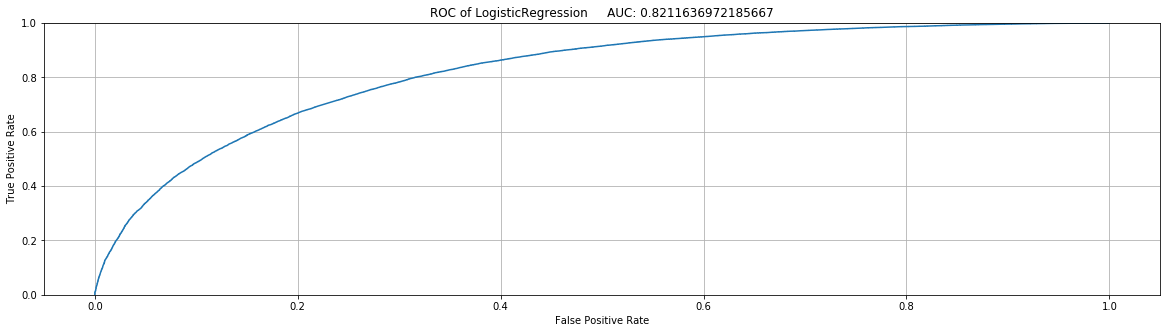


------------------------------------ MultinomialNB ------------------------------------
    
-> Test Accuracy: MultinomialNB test accuracy = 0.73675


-> General Report:

              precision    recall  f1-score   support

          0       0.73      0.75      0.74     30083
          1       0.74      0.72      0.73     29917

avg / total       0.74      0.74      0.74     60000
 


-> ROC plot and Corresponding AUC: 

 Classifier MultinomialNB area under curve of ROC is 0.8169530988776648



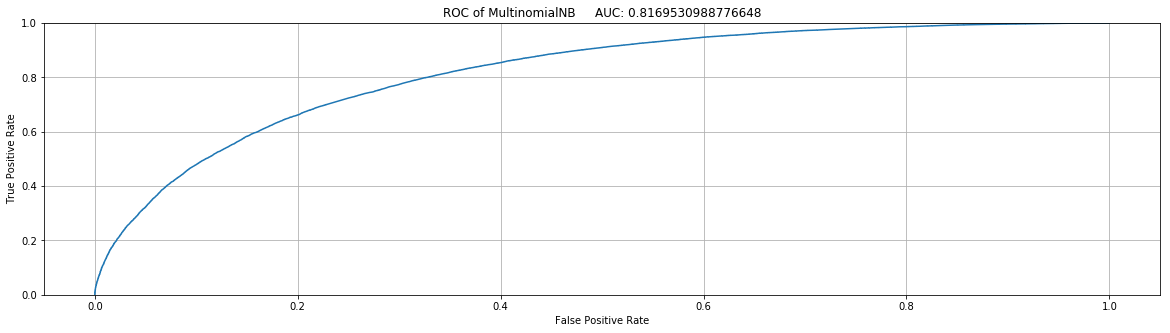


------------------------------------ BernoulliNB ------------------------------------
    
-> Test Accuracy: BernoulliNB test accuracy = 0.7370333333333333


-> General Report:

              precision    recall  f1-score   support

          0       0.72      0.78      0.75     30083
          1       0.76      0.70      0.73     29917

avg / total       0.74      0.74      0.74     60000
 


-> ROC plot and Corresponding AUC: 

 Classifier BernoulliNB area under curve of ROC is 0.8134425053393547



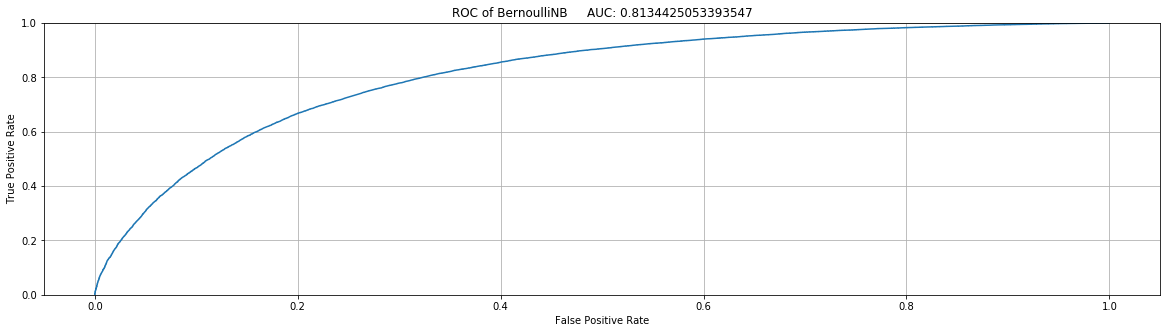

In [30]:
for name,model in thisClassifiers.models.items():
    print("""
------------------------------------ {} ------------------------------------
    """.format(name))
    thisClassifiers.prediction_metrics(X_test,y_test,name)